In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 80016 (Aurora, CO)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Aurora = melted[melted.RegionName == 33598]
Aurora = Aurora.resample('MS').mean()
Aurora = Aurora.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

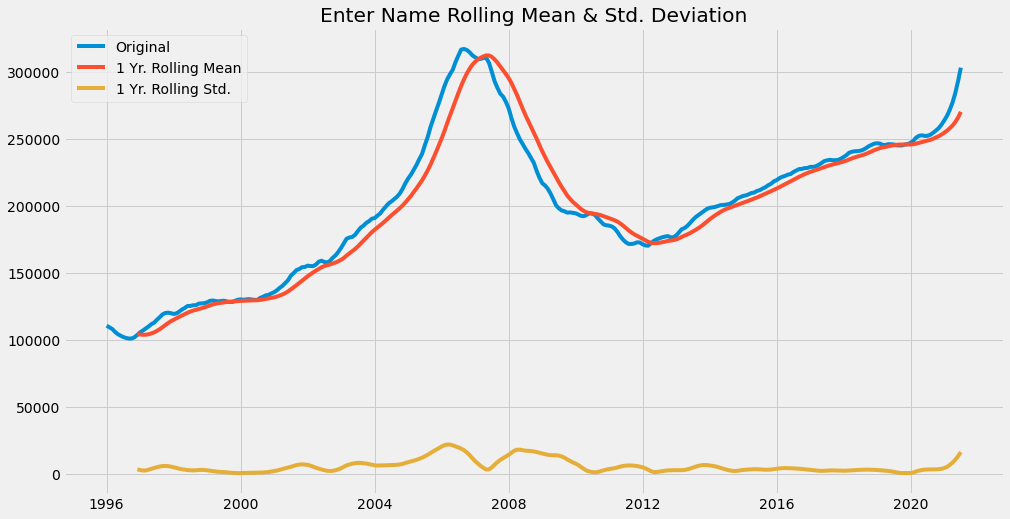

In [6]:
roll_mean_std(Aurora)

### Seasonal Decompose

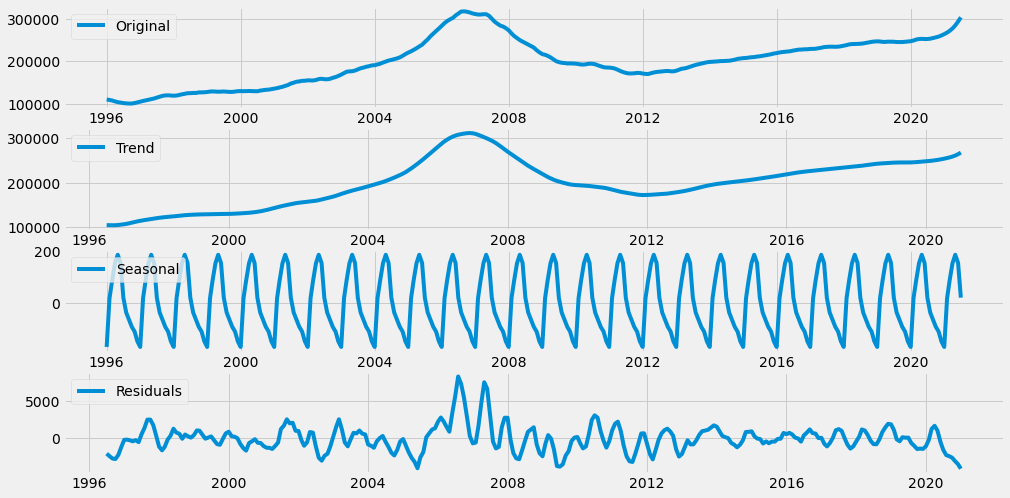

In [7]:
decompose(Aurora)

### Differencing and DickeyFuller Test

In [8]:
DickeyFullerTest(Aurora)

Test Statistic                  -0.453952
p-value                          0.900694
# Lags Used                     16.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64

Test Statistic                  -2.131438
p-value                          0.232063
# Lags Used                     16.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

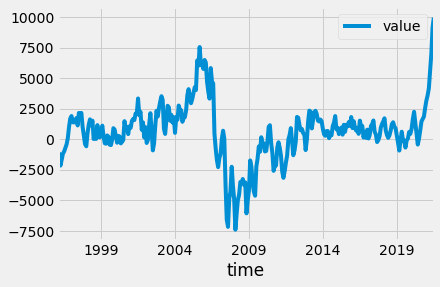

In [9]:
Aurora_diff = Aurora.diff().dropna()
Aurora_diff.plot()
DickeyFullerTest(Aurora_diff)

Test Statistic                  -3.141666
p-value                          0.023620
# Lags Used                     15.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

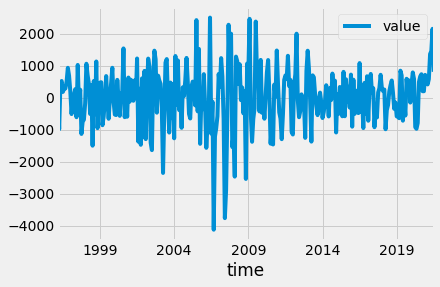

In [10]:
Aurora_diff2 = Aurora_diff.diff().dropna()
Aurora_diff2.plot()
DickeyFullerTest(Aurora_diff2)

### ACF and PACF

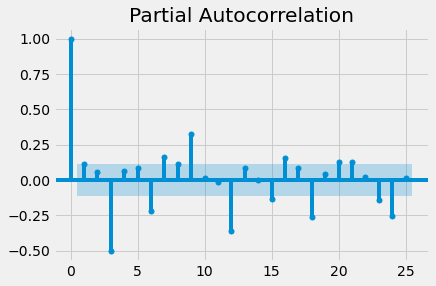

In [11]:
plot_pacf(Aurora_diff2);

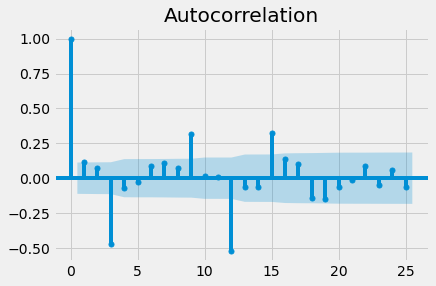

In [12]:
plot_acf(Aurora_diff2);

### Train Test Split

In [13]:
cutoff = round(Aurora.shape[0]*.8)
train = Aurora[:cutoff]
test = Aurora[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 2461.53
The Naive Model RMSE for the test data is: 2432.16


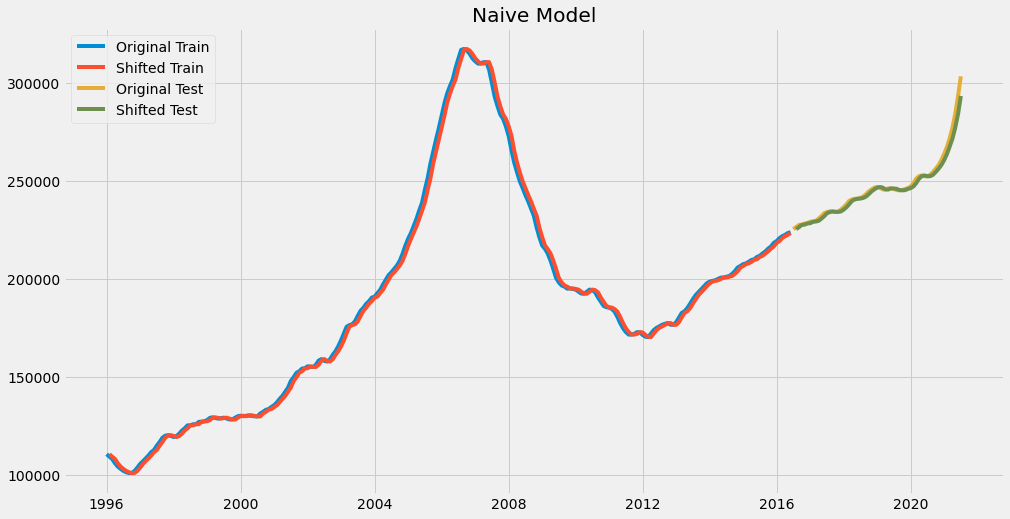

In [14]:
naive_model(train, test)

### Random Walk

In [15]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

2461.5259644109765

### Auto ARIMA

In [16]:
auto_Jacksonville = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4516.681, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4492.997, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4494.467, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4523.465, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4494.387, Time=0.43 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4494.624, Time=1.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4495.094, Time=1.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4493.083, Time=0.55 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4512.252, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4482.230, Time=0.70 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=4484.703, Time=0.36 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=4483.870, Time=1.57 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(2,1,0)(0,0,1)[12] inte

In [17]:
sarimax_model = SARIMAX(train, order=(9,1,1), seasonal_order=(0,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[2:], yhat_train[2:]))
RMSE

2719.0009148302142

### SARIMAX GridSearch and Model

In [18]:
sarimax_search(train, p=range(1,3), d=range(1,3), q=range(1,2), maxiter=100)

THERE ARE 16 ITERATIONS
Would you like to run the models? (y or n)?y
SARIMAX (1, 1, 1) x (1, 1, 1, 12) - RMSE:9242.37435764888
SARIMAX (1, 1, 1) x (1, 2, 1, 12) - RMSE:11635.688231160058
SARIMAX (1, 1, 1) x (2, 1, 1, 12) - RMSE:9303.677517649192
SARIMAX (1, 1, 1) x (2, 2, 1, 12) - RMSE:11814.500962164948
SARIMAX (1, 2, 1) x (1, 1, 1, 12) - RMSE:10698.638996848666
SARIMAX (1, 2, 1) x (1, 2, 1, 12) - RMSE:13019.543194503784
SARIMAX (1, 2, 1) x (2, 1, 1, 12) - RMSE:10083.667769979364
SARIMAX (1, 2, 1) x (2, 2, 1, 12) - RMSE:12147.771489507653
SARIMAX (2, 1, 1) x (1, 1, 1, 12) - RMSE:9518.115320140123
SARIMAX (2, 1, 1) x (1, 2, 1, 12) - RMSE:13912.937200292003
SARIMAX (2, 1, 1) x (2, 1, 1, 12) - RMSE:9596.43952903486
SARIMAX (2, 1, 1) x (2, 2, 1, 12) - RMSE:14087.59760817965
SARIMAX (2, 2, 1) x (1, 1, 1, 12) - RMSE:9745.982543384964
SARIMAX (2, 2, 1) x (1, 2, 1, 12) - RMSE:12552.648451158371
SARIMAX (2, 2, 1) x (2, 1, 1, 12) - RMSE:9646.171312556171
SARIMAX (2, 2, 1) x (2, 2, 1, 12) - RMSE

### Facebook Prophet Model

In [19]:
Aurora_proph = Aurora.reset_index()
Aurora_proph = Aurora_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 2467.027752383413
%RMSE:  y    0.012394
dtype: float64


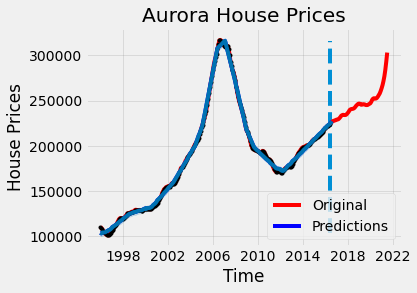

In [20]:
fbprophet_func(Aurora_proph, city = 'Aurora', periods=2)

### LSTM Model

In [21]:
history = LSTM_func(Aurora_proph, City='Aurora', epochs=200, use_multiprocessing=True, verbose = 0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
RMSE: 5333.218426505019
%RMSE:  4863.644409472292


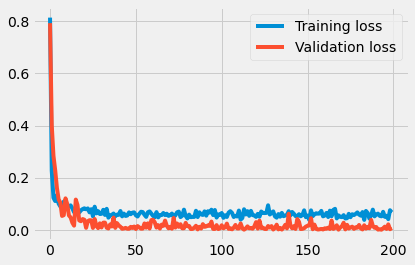

In [22]:
LSTM_val(history)

# Best Model

#### Will now try and predict the value of houes 1 year from now using Prophet.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


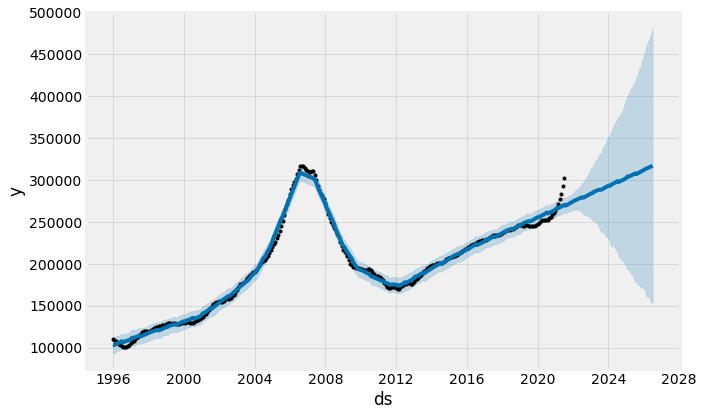

In [23]:
final_model = Prophet(interval_width=.95)
final_model.fit(Aurora_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

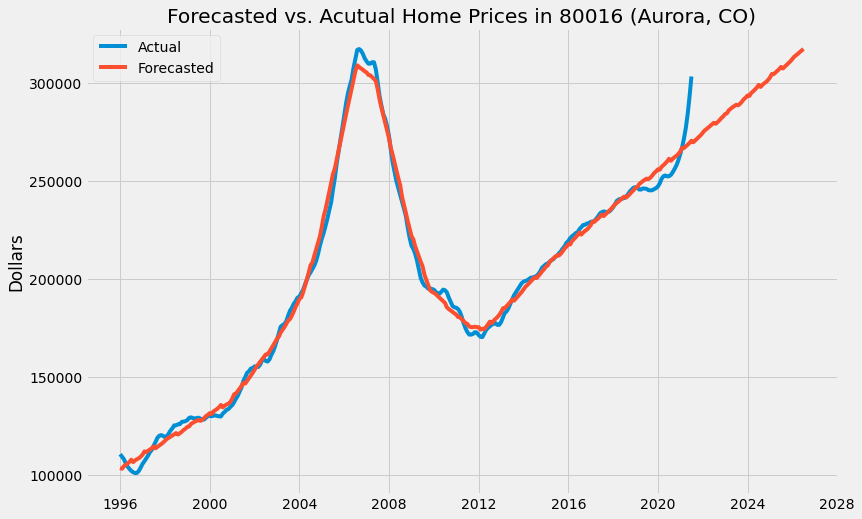

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Aurora_proph.ds, Aurora_proph.y, label='Actual')
ax.plot(forecast.ds, forecast.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 80016 (Aurora, CO)')
ax.set_ylabel('Dollars')
ax.legend();

In [25]:
current_price = int(Aurora_proph[Aurora_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $303145
Predicted 2026 price:         $317179
Predicted five year increase: $14034
Predicted five year ROI:      0.04629467746457966
